# Projeto 2: Classificação de Lixo para Reciclagem

Alunos:
- André Yudji Silva Okimoto
- Carolina Falabelo Maycá
- Fernando Lucas Nascimento Almeida
- Guilherme Dias Correa
- Luiza da Costa Caxeixa
- Sofia de Castro Sato

Link para a base de dados do trabalho (garbage classication):

https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification

<div style="max-width: 100%;">
  <img src="https://lepageandsons.com/wp-content/uploads/2021/04/Garbage-Depositphotos_180449132_xl-2015-1210x423.jpg" style="width: 100%; height: auto;box-shadow: 2px 2px 5px rgba(0, 0, 0, 0.5);">
</div>

Neste trabalho, seguimos o modelo de notebook recomendado no trabalho:

https://www.kaggle.com/code/farnazmirfeizi/trash-garbage-type-detection-using-cnn

Além disso, fizemos alterações de maneira que pudéssemos avaliar o modelo sem data augmentation, criando dois modelos: primeiro um COM data augmentation, e o segundo SEM data agumentation. Isso foi para poder realizar a avaliação pedida "Uma breve conclusão sobre o impacto do data augmentation no desempenho do
modelo."

O trabalho foi rodado no Google Colab para aproveitar a GPU que eles proporcionam, e depois o notebook foi salvo no github com as devidas alterações

## Importação de bibliotecas

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.utils as utils
from   tensorflow.keras.preprocessing.image import ImageDataGenerator
from   tensorflow.keras.models import Sequential
from   tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, ZeroPadding2D
from   tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from   tensorflow.keras.utils import plot_model
from   tensorflow.keras.callbacks import ModelCheckpoint
from   pathlib import Path
from   tensorflow.keras import models, layers, optimizers
from   sklearn.utils.class_weight import compute_class_weight
import kagglehub
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


In [2]:
warnings.filterwarnings("ignore")

## Lendo e criando arquivos

In [5]:
data_path = kagglehub.dataset_download("asdasdasasdas/garbage-classification")

print("Path to dataset files:", data_path)

Using Colab cache for faster access to the 'garbage-classification' dataset.
Path to dataset files: /kaggle/input/garbage-classification


In [ ]:
print(os.listdir(data_path))

['one-indexed-files-notrash_val.txt', 'one-indexed-files-notrash_train.txt', 'Garbage classification', 'garbage classification', 'zero-indexed-files.txt', 'one-indexed-files.txt', 'one-indexed-files-notrash_test.txt']


In [6]:
print(os.listdir(data_path + "/Garbage classification/Garbage classification"))

['metal', 'glass', 'paper', 'trash', 'cardboard', 'plastic']


In [7]:
# entrando no diretório correto para pegar nossa base de dados
data_path +=  "/Garbage classification/Garbage classification"

In [8]:
main_folder_path = Path(data_path)

all_folders = [d for d in main_folder_path.glob('**/') if d.is_dir() and d.name != main_folder_path.name]

# conta o número de arquivos nos diretórios
data = []
for folder in all_folders:
    folder_name = folder.name
    file_count = len(list(folder.glob('*.*')))
    if folder_name != data_path:
        data.append({'Folder Name': folder_name, 'File Count': file_count})

count = pd.DataFrame(data)

count = count.set_index('Folder Name')
count

,File Count
Folder Name,
metal,410
glass,501
paper,594
trash,137
cardboard,403
plastic,482


In [ ]:
print(f'Total {count.sum()}')

Total File Count    2527
dtype: int64


In [ ]:
# Mostra 5 imagens de cada classe
def plot_imgs(item_dir, top=10):
    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:5]

    plt.figure(figsize=(10, 10))

    for idx, img_path in enumerate(item_files):
        plt.subplot(5, 5, idx+1)

        img = plt.imread(img_path)
        plt.tight_layout()
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(os.path.basename(item_dir))

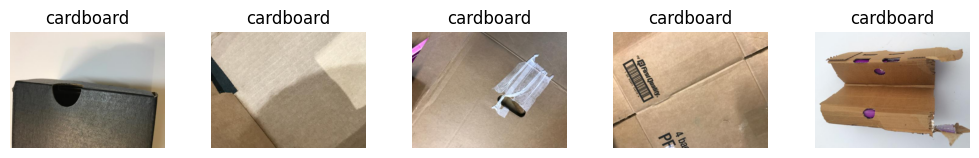

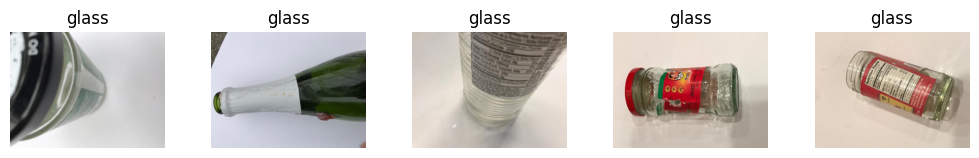

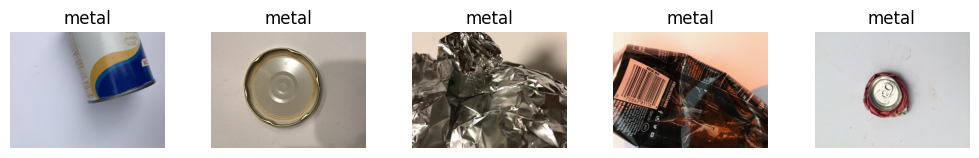

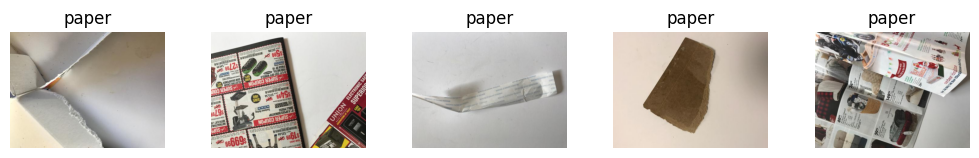

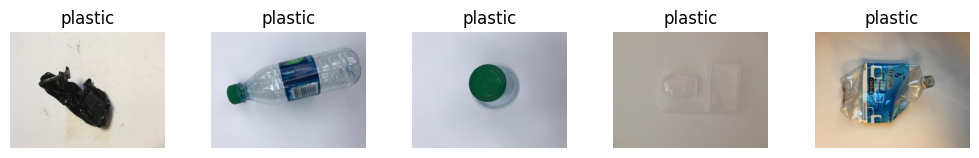

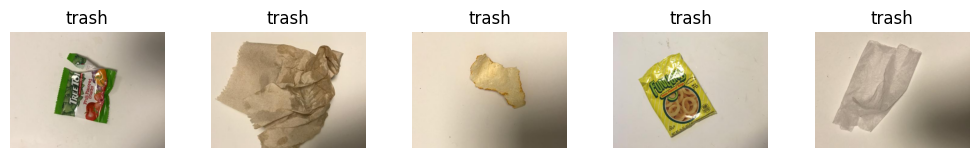

In [ ]:
plot_imgs(data_path+'/cardboard')
plot_imgs(data_path+'/glass')
plot_imgs(data_path+'/metal')
plot_imgs(data_path+'/paper')
plot_imgs(data_path+'/plastic')
plot_imgs(data_path+'/trash')

## Preparação para geração de dados usando ImageDataGenerator

In [20]:
# Variáveis para treinamento
batch_size = 30
target_size = (180, 180) # redimensionamento das imagens
validation_split = 0.15

In [ ]:
# Geradores de dados
train_img_generator = ImageDataGenerator(rescale=1./255,
                                         validation_split=validation_split,
                                         horizontal_flip=True,
                                         vertical_flip=True,
                                         zoom_range = 0.5,
                                         width_shift_range = 0.3,
                                         height_shift_range = 0.3,
                                         rotation_range=50,
                                         shear_range = 0.3,
                                         fill_mode='nearest'
                                        )

test_data_img_generator = ImageDataGenerator(rescale=1./255,
                                             validation_split=validation_split
                                            )

## Separação dos dados de treinamento e teste

In [ ]:
# Separate train Data
train_data = train_img_generator.flow_from_directory(data_path,
                                                        subset="training",
                                                        seed=133,
                                                        target_size=target_size,
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        color_mode='rgb',
                                                       )

Found 2150 images belonging to 6 classes.


In [ ]:
# Separate validation Data
test_data = test_data_img_generator.flow_from_directory(data_path,
                                                        subset="validation",
                                                        seed=133,
                                                        target_size=target_size,
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        color_mode='rgb',
                                                       )

Found 377 images belonging to 6 classes.


## Arquitetura do nosso modelo CNN

Aqui, nós mantemos o modelo do notebook base, já que ele mantém uma estrutura que foi pedida no projeto 2: "(ex: 2-3 blocos de Conv2D -> ReLU -> MaxPooling2D) seguida por um classificador (Flatten -> Dense -> Dropout -> Dense).

In [ ]:
model = Sequential()
model.add(ZeroPadding2D(padding=(1, 1), input_shape=(target_size[0], target_size[1], 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Dropout(0.3))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Dropout(0.3))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Dropout(0.4))
model.add(MaxPool2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(Dense(6, activation='softmax'))

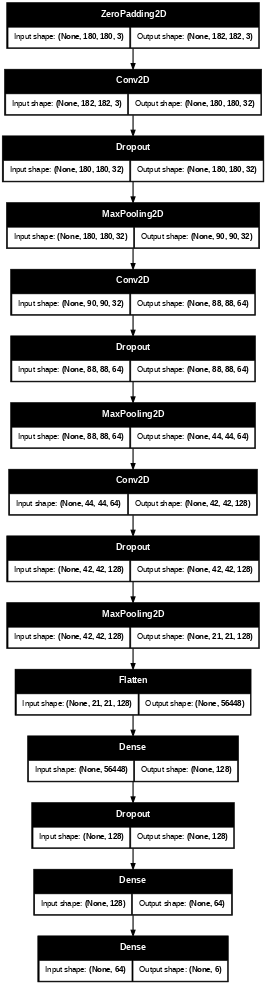

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=False, dpi=40)

## Compilador do modelo

In [ ]:
ES = EarlyStopping(monitor='val_loss', mode='min', patience=10)

RLROP = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.1, min_lr=0.01)

MCH = ModelCheckpoint('trash.keras', monitor='val_loss', mode='min', save_best_only=True)

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()]
             )

## Criando algumas funções para avaliar os modelos

Aqui, definimos uma função que vai auxiliar a avaliar o modelo com e sem data augmentation. Um plota a matriz de confusão do modelo e o outro plota a acurácia do modelo ao longo do treinamento

In [17]:
def matriz_confusao(model, test_data_img_generator):
  # recriando o gerador para os testes
  eval_generator = test_data_img_generator.flow_from_directory(
      data_path,
      subset="validation",
      seed=133,                # Mesmo seed do treino para garantir os mesmos dados
      target_size=target_size,
      batch_size=batch_size,
      class_mode='categorical',
      shuffle=False
  )

  Y_pred = model.predict(eval_generator)

  y_pred = np.argmax(Y_pred, axis=1)

  y_true = eval_generator.classes

  cm = confusion_matrix(y_true, y_pred)

  # gráfico
  class_labels = list(eval_generator.class_indices.keys())

  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
              xticklabels=class_labels,
              yticklabels=class_labels)

  plt.xlabel('Classe predita')
  plt.ylabel('Classe real')
  plt.title('Matriz de Confusão')
  plt.show()

In [18]:
def acuracia_durante_treino(history):
  best_score = max(history.history['val_categorical_accuracy'] )
  print(f"Melhor acurácia durante o treino: {best_score}")

  # Accuracy on train data :
  accuracy = history.history['categorical_accuracy']

  # Accuracy on test data :
  val_accuracy = history.history['val_categorical_accuracy']
  epochs = range(1, len(accuracy) + 1)  # Epochs

  # Accuracy line plot :
  plt.figure(figsize=(10, 5))
  plt.plot(epochs, accuracy, 'b', label='acurácia no treinamento')
  plt.plot(epochs, val_accuracy, 'r', label='acurácia na validação')
  plt.title('Acurácia ao longo do treinamento')
  plt.xlabel('Época')
  plt.ylabel('Acurácia')
  plt.legend()
  plt.show()

## Treinando o modelo com data augmentation

In [ ]:
history = model.fit(train_data,
                    steps_per_epoch=len(train_data),
                    epochs=500,
                    validation_data=test_data,
                    validation_steps=len(test_data),
                    callbacks=[ES, RLROP, MCH]
                   )

Epoch 1/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - categorical_accuracy: 0.2209 - loss: 1.8622

72/72 ━━━━━━━━━━━━━━━━━━━━ 48s 512ms/step - categorical_accuracy: 0.2214 - loss: 1.8606 - val_categorical_accuracy: 0.3369 - val_loss: 1.6897 - learning_rate: 0.0010
Epoch 2/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - categorical_accuracy: 0.3183 - loss: 1.5833

72/72 ━━━━━━━━━━━━━━━━━━━━ 22s 303ms/step - categorical_accuracy: 0.3188 - loss: 1.5827 - val_categorical_accuracy: 0.2573 - val_loss: 1.6684 - learning_rate: 0.0010
Epoch 3/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - categorical_accuracy: 0.3619 - loss: 1.5219

72/72 ━━━━━━━━━━━━━━━━━━━━ 22s 307ms/step - categorical_accuracy: 0.3622 - loss: 1.5213 - val_categorical_accuracy: 0.3607 - val_loss: 1.5633 - learning_rate: 0.0010
Epoch 4/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - categorical_accuracy: 0.4048 - loss: 1.4360

72/72 ━━━━━━━━━━━━━━━━━━━━ 22s 308ms/step - categorical_accuracy: 0.4050 - loss: 1.4359 - val_categorical_accuracy: 0.3714 - val_loss: 1.5546 - learning_rate: 0.0010
Epoch 5/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - categorical_accuracy: 0.4511 - loss: 1.3941

72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 296ms/step - categorical_accuracy: 0.4511 - loss: 1.3941 - val_categorical_accuracy: 0.4297 - val_loss: 1.5041 - learning_rate: 0.0010
Epoch 6/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 23s 318ms/step - categorical_accuracy: 0.4713 - loss: 1.3341 - val_categorical_accuracy: 0.3846 - val_loss: 1.5445 - learning_rate: 0.0010
Epoch 7/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 22s 299ms/step - categorical_accuracy: 0.4736 - loss: 1.3807 - val_categorical_accuracy: 0.4058 - val_loss: 1.5519 - learning_rate: 0.0010
Epoch 8/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - categorical_accuracy: 0.4575 - loss: 1.3396

72/72 ━━━━━━━━━━━━━━━━━━━━ 22s 307ms/step - categorical_accuracy: 0.4578 - loss: 1.3393 - val_categorical_accuracy: 0.4430 - val_loss: 1.4570 - learning_rate: 0.0010
Epoch 9/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - categorical_accuracy: 0.5126 - loss: 1.2604

72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 298ms/step - categorical_accuracy: 0.5126 - loss: 1.2606 - val_categorical_accuracy: 0.4907 - val_loss: 1.4175 - learning_rate: 0.0010
Epoch 10/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 287ms/step - categorical_accuracy: 0.5187 - loss: 1.2467 - val_categorical_accuracy: 0.4854 - val_loss: 1.4296 - learning_rate: 0.0010
Epoch 11/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 22s 304ms/step - categorical_accuracy: 0.5378 - loss: 1.2069 - val_categorical_accuracy: 0.4509 - val_loss: 1.4578 - learning_rate: 0.0010
Epoch 12/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 297ms/step - categorical_accuracy: 0.5470 - loss: 1.2339 - val_categorical_accuracy: 0.4695 - val_loss: 1.5203 - learning_rate: 0.0010
Epoch 13/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 297ms/step - categorical_accuracy: 0.5097 - loss: 1.2624 - val_categorical_accuracy: 0.4589 - val_loss: 1.4241 - learning_rate: 0.0010
Epoch 14/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 287ms/step - categorical_accuracy: 0.5821 - loss: 1.1081 - val_categorical

72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 294ms/step - categorical_accuracy: 0.5571 - loss: 1.1632 - val_categorical_accuracy: 0.5172 - val_loss: 1.3303 - learning_rate: 0.0010
Epoch 18/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 22s 305ms/step - categorical_accuracy: 0.5725 - loss: 1.1554 - val_categorical_accuracy: 0.4297 - val_loss: 1.5689 - learning_rate: 0.0010
Epoch 19/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 22s 302ms/step - categorical_accuracy: 0.5142 - loss: 1.2726 - val_categorical_accuracy: 0.5119 - val_loss: 1.3710 - learning_rate: 0.0010
Epoch 20/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 22s 305ms/step - categorical_accuracy: 0.5574 - loss: 1.1418 - val_categorical_accuracy: 0.4801 - val_loss: 1.3898 - learning_rate: 0.0010
Epoch 21/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 292ms/step - categorical_accuracy: 0.5495 - loss: 1.1879 - val_categorical_accuracy: 0.5093 - val_loss: 1.3992 - learning_rate: 0.0010
Epoch 22/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 296ms/step - categorical_accuracy: 0.5762 - loss: 1.1005 - val_categorical

72/72 ━━━━━━━━━━━━━━━━━━━━ 22s 302ms/step - categorical_accuracy: 0.5984 - loss: 1.0641 - val_categorical_accuracy: 0.5279 - val_loss: 1.3128 - learning_rate: 0.0010
Epoch 24/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 22s 304ms/step - categorical_accuracy: 0.5834 - loss: 1.0808 - val_categorical_accuracy: 0.4509 - val_loss: 1.4017 - learning_rate: 0.0010
Epoch 25/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 291ms/step - categorical_accuracy: 0.5946 - loss: 1.1054 - val_categorical_accuracy: 0.4721 - val_loss: 1.4037 - learning_rate: 0.0010
Epoch 26/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 294ms/step - categorical_accuracy: 0.5950 - loss: 1.0590 - val_categorical_accuracy: 0.5305 - val_loss: 1.3290 - learning_rate: 0.0010
Epoch 27/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 22s 301ms/step - categorical_accuracy: 0.6084 - loss: 1.0431 - val_categorical_accuracy: 0.5332 - val_loss: 1.3417 - learning_rate: 0.0010
Epoch 28/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 22s 301ms/step - categorical_accuracy: 0.6285 - loss: 1.0078 - val_categorical

72/72 ━━━━━━━━━━━━━━━━━━━━ 22s 303ms/step - categorical_accuracy: 0.5949 - loss: 1.0683 - val_categorical_accuracy: 0.4881 - val_loss: 1.3102 - learning_rate: 0.0010
Epoch 33/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 286ms/step - categorical_accuracy: 0.6266 - loss: 0.9897 - val_categorical_accuracy: 0.4801 - val_loss: 1.3854 - learning_rate: 0.0010
Epoch 34/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - categorical_accuracy: 0.6301 - loss: 1.0061

72/72 ━━━━━━━━━━━━━━━━━━━━ 22s 300ms/step - categorical_accuracy: 0.6300 - loss: 1.0062 - val_categorical_accuracy: 0.5279 - val_loss: 1.3037 - learning_rate: 0.0010
Epoch 35/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 22s 301ms/step - categorical_accuracy: 0.6164 - loss: 1.0336 - val_categorical_accuracy: 0.5013 - val_loss: 1.3539 - learning_rate: 0.0010
Epoch 36/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 297ms/step - categorical_accuracy: 0.5828 - loss: 1.0938 - val_categorical_accuracy: 0.4456 - val_loss: 1.4109 - learning_rate: 0.0010
Epoch 37/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 286ms/step - categorical_accuracy: 0.6052 - loss: 1.0235 - val_categorical_accuracy: 0.4615 - val_loss: 1.4476 - learning_rate: 0.0010
Epoch 38/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 22s 300ms/step - categorical_accuracy: 0.6268 - loss: 1.0387 - val_categorical_accuracy: 0.5411 - val_loss: 1.3558 - learning_rate: 0.0010
Epoch 39/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - categorical_accuracy: 0.6065 - loss: 1.0085

72/72 ━━━━━━━━━━━━━━━━━━━━ 22s 300ms/step - categorical_accuracy: 0.6068 - loss: 1.0082 - val_categorical_accuracy: 0.5305 - val_loss: 1.2762 - learning_rate: 0.0010
Epoch 40/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 296ms/step - categorical_accuracy: 0.6453 - loss: 0.9816 - val_categorical_accuracy: 0.5358 - val_loss: 1.3306 - learning_rate: 0.0010
Epoch 41/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 291ms/step - categorical_accuracy: 0.6517 - loss: 0.9303 - val_categorical_accuracy: 0.5358 - val_loss: 1.3787 - learning_rate: 0.0010
Epoch 42/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 22s 299ms/step - categorical_accuracy: 0.6424 - loss: 0.9741 - val_categorical_accuracy: 0.4907 - val_loss: 1.3255 - learning_rate: 0.0010
Epoch 43/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - categorical_accuracy: 0.6466 - loss: 0.9467

72/72 ━━━━━━━━━━━━━━━━━━━━ 22s 301ms/step - categorical_accuracy: 0.6464 - loss: 0.9469 - val_categorical_accuracy: 0.5676 - val_loss: 1.2727 - learning_rate: 0.0010
Epoch 44/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 26s 364ms/step - categorical_accuracy: 0.6268 - loss: 0.9573 - val_categorical_accuracy: 0.5146 - val_loss: 1.3252 - learning_rate: 0.0010
Epoch 45/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 36s 301ms/step - categorical_accuracy: 0.6493 - loss: 0.9253 - val_categorical_accuracy: 0.5332 - val_loss: 1.3386 - learning_rate: 0.0010
Epoch 46/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - categorical_accuracy: 0.6601 - loss: 0.8977

72/72 ━━━━━━━━━━━━━━━━━━━━ 22s 303ms/step - categorical_accuracy: 0.6600 - loss: 0.8981 - val_categorical_accuracy: 0.5676 - val_loss: 1.2307 - learning_rate: 0.0010
Epoch 47/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 292ms/step - categorical_accuracy: 0.6672 - loss: 0.9049 - val_categorical_accuracy: 0.5199 - val_loss: 1.3595 - learning_rate: 0.0010
Epoch 48/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 22s 298ms/step - categorical_accuracy: 0.6661 - loss: 0.9005 - val_categorical_accuracy: 0.5305 - val_loss: 1.3202 - learning_rate: 0.0010
Epoch 49/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 22s 300ms/step - categorical_accuracy: 0.6662 - loss: 0.8951 - val_categorical_accuracy: 0.5623 - val_loss: 1.3166 - learning_rate: 0.0010
Epoch 50/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 22s 301ms/step - categorical_accuracy: 0.6505 - loss: 0.9798 - val_categorical_accuracy: 0.5093 - val_loss: 1.4070 - learning_rate: 0.0010
Epoch 51/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 22s 302ms/step - categorical_accuracy: 0.6372 - loss: 1.0074 - val_categorical

72/72 ━━━━━━━━━━━━━━━━━━━━ 22s 303ms/step - categorical_accuracy: 0.6730 - loss: 0.8783 - val_categorical_accuracy: 0.5676 - val_loss: 1.2091 - learning_rate: 0.0010
Epoch 55/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 298ms/step - categorical_accuracy: 0.6774 - loss: 0.8688 - val_categorical_accuracy: 0.5570 - val_loss: 1.2866 - learning_rate: 0.0010
Epoch 56/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 285ms/step - categorical_accuracy: 0.6383 - loss: 0.9942 - val_categorical_accuracy: 0.5676 - val_loss: 1.2617 - learning_rate: 0.0010
Epoch 57/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 22s 300ms/step - categorical_accuracy: 0.6730 - loss: 0.9165 - val_categorical_accuracy: 0.5464 - val_loss: 1.2541 - learning_rate: 0.0010
Epoch 58/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 22s 299ms/step - categorical_accuracy: 0.6700 - loss: 0.9159 - val_categorical_accuracy: 0.5305 - val_loss: 1.2714 - learning_rate: 0.0010
Epoch 59/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 22s 300ms/step - categorical_accuracy: 0.6795 - loss: 0.8708 - val_categorical

In [ ]:
model.save('CNN_com_data_augmentation.keras')

## Avaliando modelo COM data augmentation

In [ ]:
loss, accuracy = model.evaluate(test_data)
print("Acurácia do modelo: ", accuracy)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - categorical_accuracy: 0.6324 - loss: 1.1691
Acurácia do modelo:  0.6021220088005066


Melhor acurácia durante o treino: 0.6021220088005066


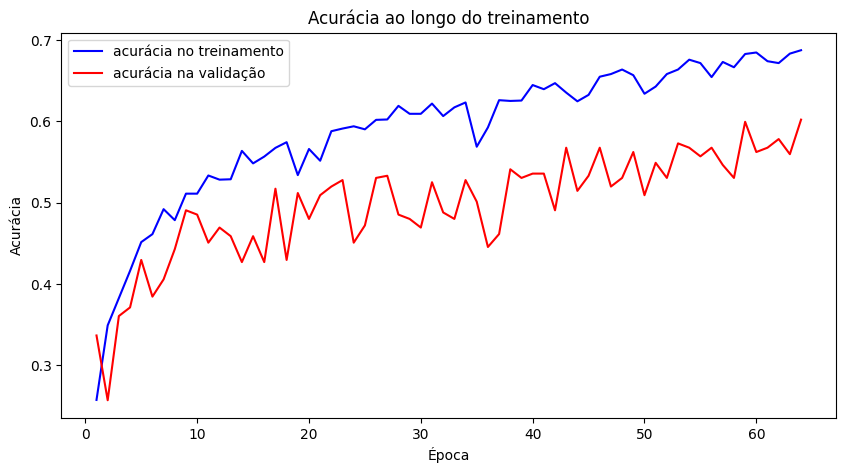

In [ ]:
acuracia_durante_treino(history)

Found 377 images belonging to 6 classes.
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step


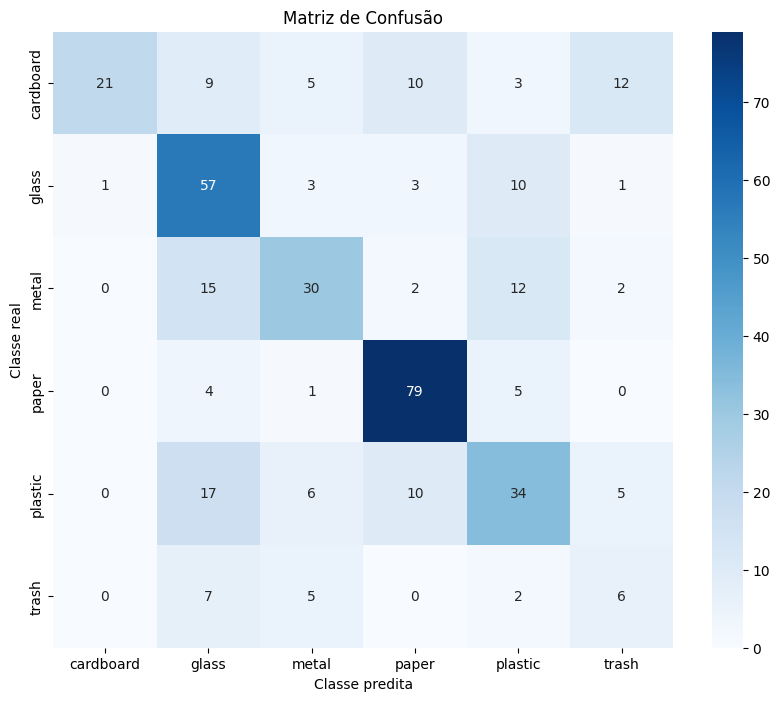

In [ ]:
matriz_confusao(model, test_data_img_generator)

## Recriando todo o experimento para o CNN sem data augmentation

In [ ]:
# Variáveis para treinamento
batch_size = 30
target_size = (180, 180) # redimensionamento das imagens
validation_split = 0.15

In [23]:
# fazendo a mesma separação do data generator, mas agora train_img_generator
# não vai fazer o data augmentation
train_img_generator = ImageDataGenerator(rescale=1./255,
                                             validation_split=validation_split
                                            )

test_data_img_generator = ImageDataGenerator(rescale=1./255,
                                             validation_split=validation_split
                                            )

train_data = train_img_generator.flow_from_directory(data_path,
                                                        subset="training",
                                                        seed=133,
                                                        target_size=target_size,
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        color_mode='rgb',
                                                       )

test_data = test_data_img_generator.flow_from_directory(data_path,
                                                        subset="validation",
                                                        seed=133,
                                                        target_size=target_size,
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        color_mode='rgb',
                                                       )

Found 2150 images belonging to 6 classes.
Found 377 images belonging to 6 classes.


In [ ]:
# mesmo modelo anterior
model = Sequential()
model.add(ZeroPadding2D(padding=(1, 1), input_shape=(target_size[0], target_size[1], 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Dropout(0.3))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Dropout(0.3))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Dropout(0.4))
model.add(MaxPool2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(Dense(6, activation='softmax'))

In [ ]:
# mesmos parâmetros de compilação
ES = EarlyStopping(monitor='val_loss', mode='min', patience=10)

RLROP = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.1, min_lr=0.01)

MCH = ModelCheckpoint('trash.keras', monitor='val_loss', mode='min', save_best_only=True)

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()]
             )

## Treinando o modelo CNN sem data augmentation

In [ ]:
history = model.fit(train_data,
                    steps_per_epoch=len(train_data),
                    epochs=500,
                    validation_data=test_data,
                    validation_steps=len(test_data),
                    callbacks=[ES, RLROP, MCH]
                   )

Epoch 1/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - categorical_accuracy: 0.2549 - loss: 1.8744

72/72 ━━━━━━━━━━━━━━━━━━━━ 17s 168ms/step - categorical_accuracy: 0.2556 - loss: 1.8717 - val_categorical_accuracy: 0.3952 - val_loss: 1.6043 - learning_rate: 0.0010
Epoch 2/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - categorical_accuracy: 0.4085 - loss: 1.4513

72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - categorical_accuracy: 0.4085 - loss: 1.4511 - val_categorical_accuracy: 0.3846 - val_loss: 1.5988 - learning_rate: 0.0010
Epoch 3/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - categorical_accuracy: 0.4353 - loss: 1.3979

72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - categorical_accuracy: 0.4354 - loss: 1.3976 - val_categorical_accuracy: 0.4271 - val_loss: 1.4878 - learning_rate: 0.0010
Epoch 4/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - categorical_accuracy: 0.4866 - loss: 1.2707

72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - categorical_accuracy: 0.4868 - loss: 1.2703 - val_categorical_accuracy: 0.4218 - val_loss: 1.4428 - learning_rate: 0.0010
Epoch 5/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - categorical_accuracy: 0.5384 - loss: 1.1748

72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - categorical_accuracy: 0.5382 - loss: 1.1753 - val_categorical_accuracy: 0.4960 - val_loss: 1.3792 - learning_rate: 0.0010
Epoch 6/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - categorical_accuracy: 0.5746 - loss: 1.1132 - val_categorical_accuracy: 0.4615 - val_loss: 1.4005 - learning_rate: 0.0010
Epoch 7/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - categorical_accuracy: 0.6126 - loss: 1.0140

72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - categorical_accuracy: 0.6126 - loss: 1.0141 - val_categorical_accuracy: 0.4987 - val_loss: 1.3737 - learning_rate: 0.0010
Epoch 8/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - categorical_accuracy: 0.6761 - loss: 0.8898

72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - categorical_accuracy: 0.6760 - loss: 0.8899 - val_categorical_accuracy: 0.5358 - val_loss: 1.2605 - learning_rate: 0.0010
Epoch 9/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - categorical_accuracy: 0.6875 - loss: 0.8429 - val_categorical_accuracy: 0.5225 - val_loss: 1.2931 - learning_rate: 0.0010
Epoch 10/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - categorical_accuracy: 0.7414 - loss: 0.6974 - val_categorical_accuracy: 0.5013 - val_loss: 1.3013 - learning_rate: 0.0010
Epoch 11/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - categorical_accuracy: 0.7535 - loss: 0.6740 - val_categorical_accuracy: 0.4987 - val_loss: 1.2727 - learning_rate: 0.0010
Epoch 12/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - categorical_accuracy: 0.7776 - loss: 0.6121

72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - categorical_accuracy: 0.7777 - loss: 0.6118 - val_categorical_accuracy: 0.5729 - val_loss: 1.1723 - learning_rate: 0.0010
Epoch 13/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - categorical_accuracy: 0.8174 - loss: 0.5066 - val_categorical_accuracy: 0.5305 - val_loss: 1.2236 - learning_rate: 0.0010
Epoch 14/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - categorical_accuracy: 0.8566 - loss: 0.4159 - val_categorical_accuracy: 0.5066 - val_loss: 1.2509 - learning_rate: 0.0010
Epoch 15/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - categorical_accuracy: 0.8709 - loss: 0.3764

72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - categorical_accuracy: 0.8708 - loss: 0.3767 - val_categorical_accuracy: 0.5650 - val_loss: 1.1673 - learning_rate: 0.0010
Epoch 16/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - categorical_accuracy: 0.8834 - loss: 0.3194 - val_categorical_accuracy: 0.5491 - val_loss: 1.2200 - learning_rate: 0.0010
Epoch 17/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - categorical_accuracy: 0.8693 - loss: 0.3596 - val_categorical_accuracy: 0.5305 - val_loss: 1.2056 - learning_rate: 0.0010
Epoch 18/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - categorical_accuracy: 0.9013 - loss: 0.2859 - val_categorical_accuracy: 0.5729 - val_loss: 1.1996 - learning_rate: 0.0010
Epoch 19/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - categorical_accuracy: 0.9077 - loss: 0.2822 - val_categorical_accuracy: 0.5252 - val_loss: 1.2287 - learning_rate: 0.0010
Epoch 20/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - categorical_accuracy: 0.8957 - loss: 0.3086 - val_categorical_accuracy: 0

72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - categorical_accuracy: 0.9278 - loss: 0.1965 - val_categorical_accuracy: 0.6048 - val_loss: 1.1647 - learning_rate: 0.0010
Epoch 24/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - categorical_accuracy: 0.9213 - loss: 0.2401 - val_categorical_accuracy: 0.5544 - val_loss: 1.2840 - learning_rate: 0.0010
Epoch 25/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - categorical_accuracy: 0.9418 - loss: 0.1834 - val_categorical_accuracy: 0.5782 - val_loss: 1.1999 - learning_rate: 0.0010
Epoch 26/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - categorical_accuracy: 0.9326 - loss: 0.1938 - val_categorical_accuracy: 0.5729 - val_loss: 1.2327 - learning_rate: 0.0010
Epoch 27/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - categorical_accuracy: 0.9325 - loss: 0.2122 - val_categorical_accuracy: 0.5570 - val_loss: 1.3549 - learning_rate: 0.0010
Epoch 28/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - categorical_accuracy: 0.9263 - loss: 0.2057 - val_categorical_accuracy: 0

In [ ]:
model.save('CNN_sem_data_augmentation.keras')

## Avaliando modelo SEM data augmentation

In [ ]:
loss, accuracy = model.evaluate(test_data)
print("Acurácia do modelo: ", accuracy)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - categorical_accuracy: 0.5871 - loss: 1.3927
Acurácia do modelo:  0.5702917575836182


Melhor acurácia durante o treino: 0.604774534702301


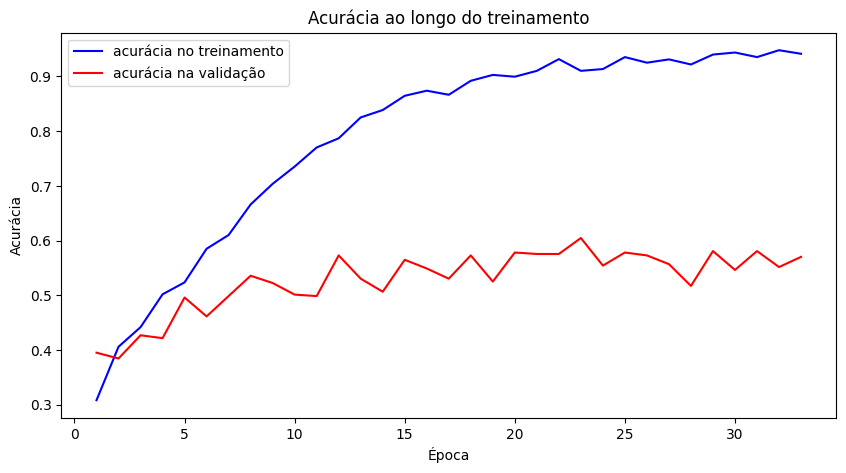

In [ ]:
acuracia_durante_treino(history)

Found 377 images belonging to 6 classes.
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step


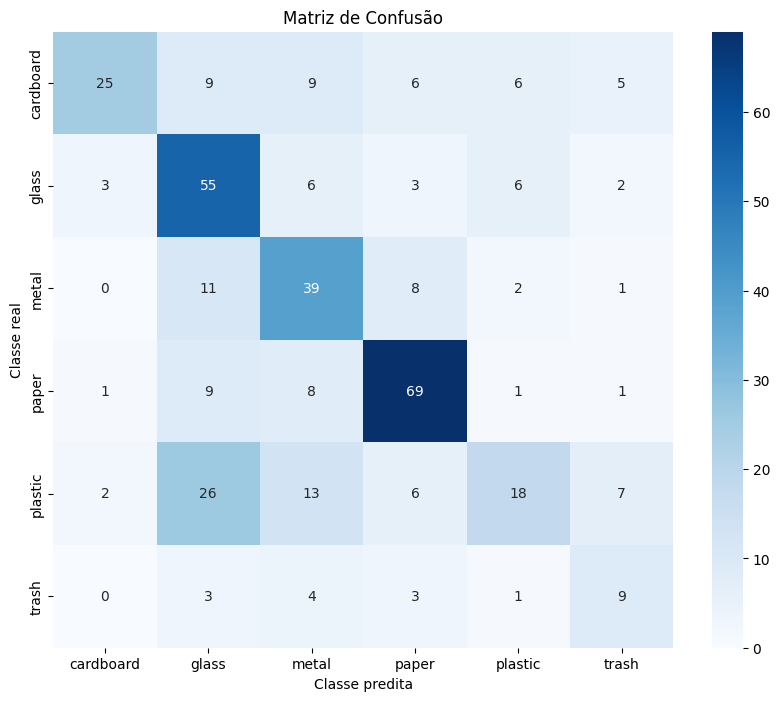

In [ ]:
matriz_confusao(model, test_data_img_generator)

## Avaliações finais e conclusões

Pelo que pudemos visualizar, ambos os modelos tiveram um certo overfitting, mas o do modelo SEM data augmentation possuiu um overfitting pior. Veja que as acurácias de treino do modelo sem data augmentation chegou a alcançar acima de 90%, enquanto do modelo COM não passou de 70%.

A acurácia final do modelo COM foi melhor que a do SEM (60.21% X 57.03%). Mas no geral, não foram muito diferentes nessa métrica.

Algumas avaliações interessantes olhando as matrizes de confusão:
- O modelo COM data augmentation teve mais dificuldade de classificar a categoria "trash" do que o modelo SEM.
- Ambos tiveram confusões entre classificar vidro, plástico e metal. Mas o modelo SEM aparenta confundir eses três muito mais. Veja que ele classificou muitas vezes um plástico (real) como vidro (predito).  
- Ambos erravam pouco quando classificava papelão, então o modelo aparentou ter "mais certeza" quando classificava algo como papelão. Mas ainda sim, eles confundiam muito papelões com os outros tipos de materiais, e acabavam classificando papelão como outro material.

## Seção opcional: Fazendo inferências com o modelo treinado

Esta seção é uma seção **extra**, caso queira fazer algum tipo de teste com os nossos modelos. O link a seguir de um drive possui os dois modelos treinados que foram vistos nas seções anteriores (COM e SEM data augmentation):

https://drive.google.com/drive/folders/1jVO079QiCGTF4RsdOaZjpmSB9xWM9eLH

É necessário baixá-los caso queira continuar nessa seção.

In [4]:
batch_size = 30
target_size_padrao = (180, 180)
validation_split = 0.15

In [10]:
# Data Generators para o modelo padrão
train_img_generator_padrao = ImageDataGenerator(rescale=1./255,
                                               validation_split=validation_split,
                                               horizontal_flip=True,
                                               vertical_flip=True,
                                               zoom_range = 0.5,
                                               width_shift_range = 0.3,
                                               height_shift_range = 0.3,
                                               rotation_range=50,
                                               shear_range = 0.3,
                                               fill_mode='nearest'
                                              )

test_data_img_generator_padrao = ImageDataGenerator(rescale=1./255,
                                                   validation_split=validation_split
                                                  )

In [11]:
# Separação dos dados de treinamento e teste para o modelo padrão
train_data_padrao = train_img_generator_padrao.flow_from_directory(data_path,
                                                                  subset="training",
                                                                  seed=133,  # Mesmo seed usado anteriormente
                                                                  target_size=target_size_padrao,
                                                                  batch_size=batch_size,
                                                                  class_mode='categorical',
                                                                  color_mode='rgb',
                                                                 )

test_data_padrao = test_data_img_generator_padrao.flow_from_directory(data_path,
                                                                     subset="validation",
                                                                     seed=133,  # Mesmo seed usado anteriormente
                                                                     target_size=target_size_padrao,
                                                                     batch_size=batch_size,
                                                                     class_mode='categorical',
                                                                     color_mode='rgb',
                                                                    )

Found 2150 images belonging to 6 classes.
Found 377 images belonging to 6 classes.


In [12]:
try:
    # Tentando carregar o modelo COM data augmentation
    model_padrao = tf.keras.models.load_model('CNN_com_data_augmentation.keras')
    print("Modelo carregado com sucesso: CNN_com_data_augmentation.keras")
    print("Arquitetura do modelo carregado (representa modelo CNN padrão):")
    model_padrao.summary()

except:
    try:
        # Se não encontrar o primeiro, tenta o segundo
        model_padrao = tf.keras.models.load_model('CNN_sem_data_augmentation.keras')
        print("Modelo carregado com sucesso: CNN_sem_data_augmentation.keras")
        print("Arquitetura do modelo carregado (representa modelo CNN padrão):")
        model_padrao.summary()

    except:
        print("Nenhum modelo .keras encontrado.")

Modelo carregado com sucesso: CNN_com_data_augmentation.keras
Arquitetura do modelo carregado (representa modelo CNN padrão):


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ zero_padding2d (ZeroPadding2D)  │ (None, 182, 182, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 180, 180, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 88, 88, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 88, 88, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 44, 44, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 42, 42, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 42, 42, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 56448)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,225,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,654,734 (55.90 MB)

 Trainable params: 7,327,366 (27.95 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,327,368 (27.95 MB)

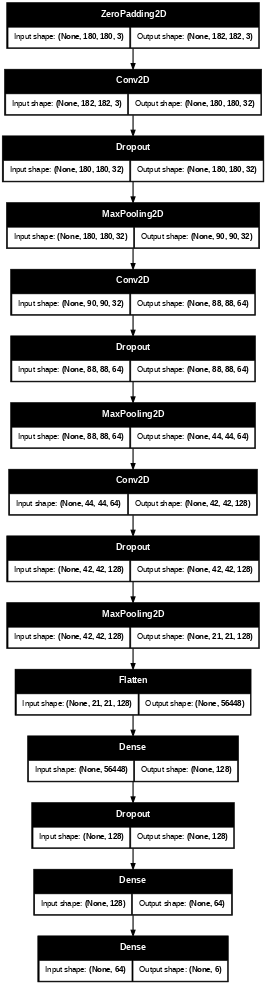

In [13]:
plot_model(model_padrao, show_shapes=True, show_layer_names=False, dpi=40)

In [14]:
# Verificando compilação do modelo
print(f"Otimizador: {model_padrao.optimizer.__class__.__name__}")
print(f"Função de perda: {model_padrao.loss}")
print(f"Métricas: {model_padrao.metrics_names}")

Otimizador: RMSprop
Função de perda: <LossFunctionWrapper(<function categorical_crossentropy at 0x7e9f3cb854e0>, kwargs={'from_logits': False, 'label_smoothing': 0.0, 'axis': -1})>
Métricas: ['loss', 'compile_metrics']


In [15]:
# Avaliação usando acurácia categórica
loss, accuracy = model_padrao.evaluate(test_data_padrao)
print("Acurácia do modelo padrão: ", accuracy)

13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 263ms/step - categorical_accuracy: 0.6327 - loss: 1.2140
Acurácia do modelo padrão:  0.6021220088005066


Found 377 images belonging to 6 classes.
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step


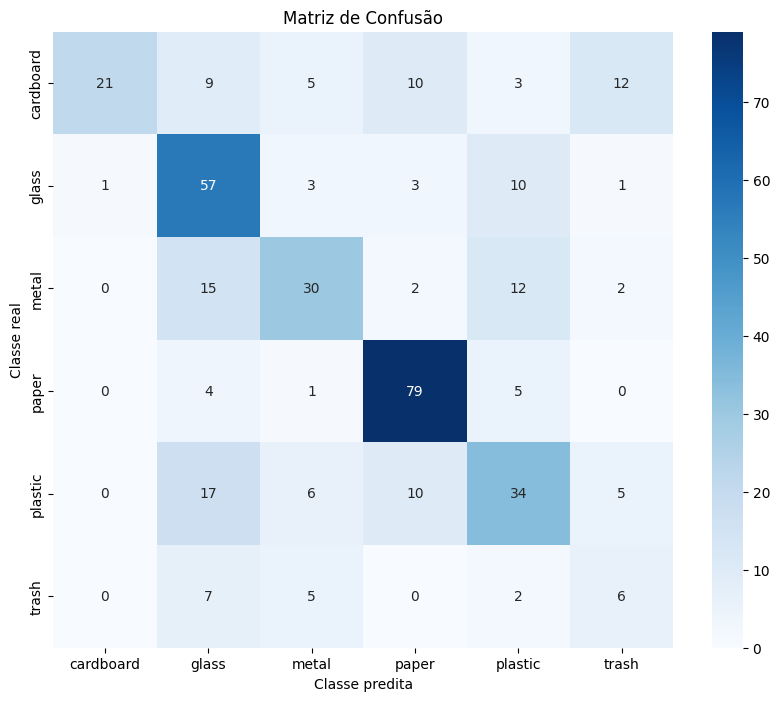

In [21]:
# Matriz de confusão
matriz_confusao(model_padrao, test_data_img_generator_padrao)

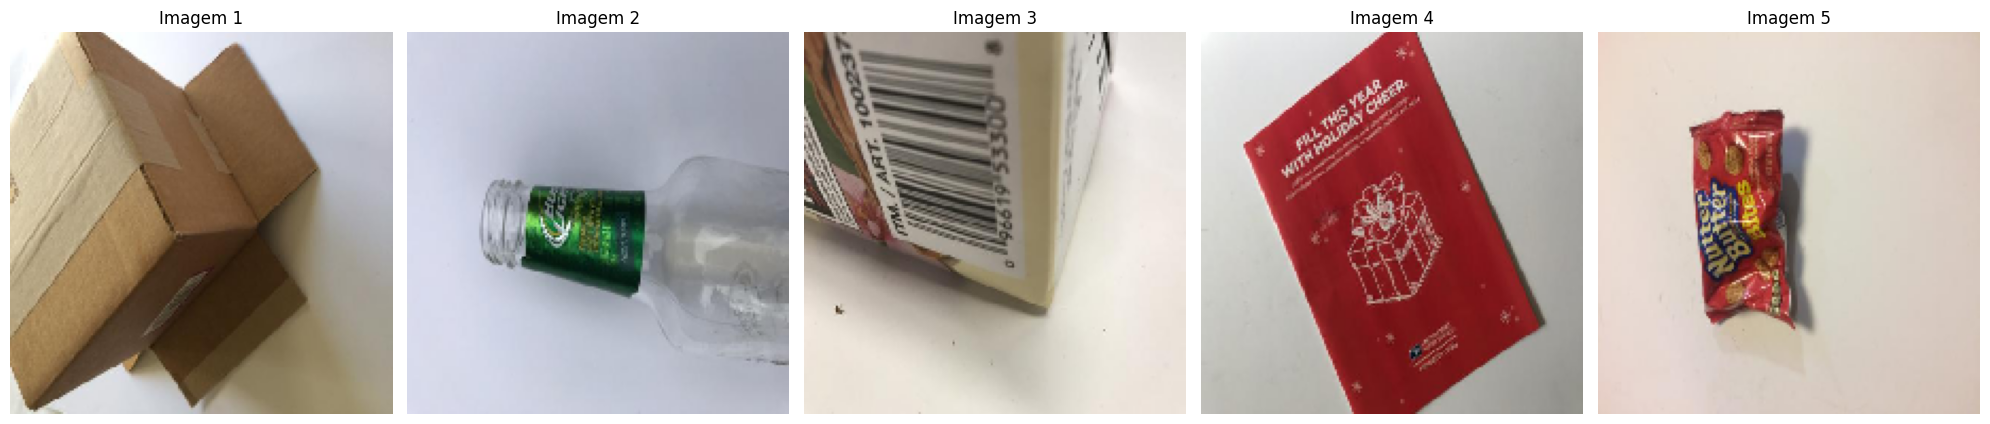


  AMOSTRA 1:
   Real: cardboard
   Predito: trash
   Confiança: 0.2566
   Probabilidades:
     cardboard : 0.2014
     glass     : 0.1625
     metal     : 0.0656
     paper     : 0.1841
     plastic   : 0.1297
     trash     : 0.2566
----------------------------------------

  AMOSTRA 2:
   Real: glass
   Predito: plastic
   Confiança: 0.4341
   Probabilidades:
     cardboard : 0.0226
     glass     : 0.2742
     metal     : 0.1867
     paper     : 0.0541
     plastic   : 0.4341
     trash     : 0.0283
----------------------------------------

  AMOSTRA 3:
   Real: cardboard
   Predito: metal
   Confiança: 0.3689
   Probabilidades:
     cardboard : 0.0115
     glass     : 0.2374
     metal     : 0.3689
     paper     : 0.1498
     plastic   : 0.1410
     trash     : 0.0913
----------------------------------------

  AMOSTRA 4:
   Real: paper
   Predito: paper
   Confiança: 0.3848
   Probabilidades:
     cardboard : 0.0109
     glass     : 0.1297
     metal     : 0.2456
     paper     

In [24]:
test_data.reset()

# Obtendo uma pequena amostra
sample_batch = next(test_data)
sample_images = sample_batch[0][:5]  # Primeiras 5 imagens
sample_labels = sample_batch[1][:5]  # Primeiras 5 labels

# Fazendo predição
y_pred_probs = model_padrao.predict(sample_images, verbose=0)
class_labels = list(test_data.class_indices.keys())

plt.figure(figsize=(20, 15))

for i in range(len(y_pred_probs)):
    # Subplot para a imagem
    plt.subplot(3, 5, i+1)
    plt.imshow(sample_images[i])
    plt.title(f"Imagem {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

for i in range(len(y_pred_probs)):
    print(f"\n  AMOSTRA {i+1}:")
    print(f"   Real: {class_labels[np.argmax(sample_labels[i])]}")
    print(f"   Predito: {class_labels[np.argmax(y_pred_probs[i])]}")
    print(f"   Confiança: {y_pred_probs[i].max():.4f}")
    print(f"   Probabilidades:")
    for j, class_name in enumerate(class_labels):
        print(f"     {class_name:10}: {y_pred_probs[i][j]:.4f}")
    print("-" * 40)